<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/09_mining/deli_proj_pract_09_mining_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Я.Практикум**</b></font>
    
<font size=6><b>**Сборный Проект №2**</b></font>

***

# Постановка задачи

**Заказчик:** ГК "Цифра", разрабатывающая решения для эффективной работы промышленных предприятий.

**Цель:** 
Оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Для этого требуется подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды (recovery).

**Задачи:** 
1. Загрузить и проанализировать данные;
1. Провести исследовательский анализ данных;
1. Подготовить данные;
1. Построить и обучить модель.

**Исходные данные:** Выгруженные из хранилища компании сырые данные с параметрами добычи и очистки, индексируемые датой и временем получения информации (признак date). 
Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. 
Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Коэффициент восстановления золота рассчитывается по формуле: 

<tex>$$Recovery=\frac{C \cdot (F - T)}{F \cdot (C - T)},$$</tex>

где:
*C* — доля золота в концентрате после флотации/очистки;  
*F* — доля золота в сырье/концентрате до флотации/очистки;  
*T* — доля золота в отвальных хвостах после флотации/очистки.  

Модель должна прогнозировать сразу две величины:  
* эффективность обогащения чернового концентрата rougher.output.recovery;  
* эффективность обогащения финального концентрата final.output.recovery.  

В качестве метрики качества обоих величин следует использовать SMAPE, а для итоговой метрики - их сумму с коэффициентами:

<tex>$$sMAPE_{total}= 0,25 \cdot sMAPE_{rougher} + 0,75 \cdot sMAPE_{final}$$</tex>

# Обзор данных

## Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer

# Темная тема графиков
plt.style.use('dark_background')

# отображение таблиц без ограничения на количество столбцов:
pd.set_option("display.max_columns", None)

try:
    import phik
except: 
    ! pip install phik
    import phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 6.8 MB/s 


Загрузим сами данные.

In [2]:
! gdown --id 1-DpZ0i7yiB_UzLxYzK5SHesDWLfzDjM2
! gdown --id 1-OKZCVhhC2peKK337tI4VS9oW16pFOW2
! gdown --id 1-2WEsLPwjLgY6zl3boaPeH36yjXdBrAs

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-DpZ0i7yiB_UzLxYzK5SHesDWLfzDjM2
To: /content/gold_recovery_train_new.csv
100% 22.8M/22.8M [00:00<00:00, 90.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-OKZCVhhC2peKK337tI4VS9oW16pFOW2
To: /content/gold_recovery_test_new.csv
100% 5.27M/5.27M [00:00<00:00, 32.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWa

In [3]:
df_train = pd.read_csv("/content/gold_recovery_full_new.csv")
df_test = pd.read_csv("/content/gold_recovery_test_new.csv")
df_full = pd.read_csv("/content/gold_recovery_full_new.csv")

## Полная выборка

Вызовем первые 5 строк, общую информацию о полной выборке, а также количество дубликатов в ней.

In [4]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [6]:
df_full.duplicated().sum()

0

Полная выборка содержит 19 439 уникальных объекта, среди которых встречаются пропуски, требующие обработки до разработки моделей.
При этом в столбце date тип хранения данных не соответствует содержимому и должен быть изменен на DateTime.

У каждого объекта по 86 признаков, не считая дату проведения измерений.
Каждый признак формируется согласно следующему правилу: [этап].[тип_параметра].[название_параметра].

Значения для блока [этап]:
1. rougher - флотация;
1. primary_cleaner - первичная очистка;
1. secondary_cleaner - вторичная очистка;
1. final - финальные характеристики.

Значения для блока [тип_параметра]:
1. input - параметры сырья;
1. output - параметры продукта;
1. state - параметры, характеризующие текущее состояние этапа;
1. calculation - расчётные характеристики.

Значения для блока [название_параметра]:
1. feed_ *El* - исходное сырье,    
    где *El* принимает значения:
        ag - серебро;
        pb - свинец;
        sol - соли;
        au - золото;
1. feed_size - размер гранул сырья;
1. feed_rate - скорость подачи сырья;
1. floatbank *N* _sulfate - количество (видимо?) сульфата в флотационной установке,
        где *N* - номер установки (видимо?);
1. floatbank *N* _xanthate - количество (видимо?) ксантогената в флотационной установке;
1. concentrate_ *El* - концентрация сырья;
1. recovery - коэффициент восстановления золота;
1. tail_ *El* - количество сырья (видимо?) в отвальных хвостах;
1. sulfate_to_au_concentrate - концентрация сульфата по отношению к золоту (видимо?);
1. floatbank *N* _sulfate_to_au_feed - количество сульфата по отношению к золоту в флотационной установке (видимо?);
1. au_pb_ratio - отношение золота к свинцу (видимо?);
1. floatbank *N* _air - объём воздуха в флотационной установке;
1. floatbank *N* _level - уровень жидкости в флотационной установке;
1. sulfate - количество (видимо?) сульфата;
1. depressant - количество (видимо?) депрессанта;
1. xanthate - количество (видимо?) ксантогената.

Целевым признаком является коэффициент восстановления золота: rougher.output.recovery и final.output.recovery.
Проверим соответствие приведенных значений этого коэффициента расчетной формуле. 
С этой целью вычислим значения коэффициента для этапа флотации и определим их среднюю абсолютную ошибку относительно значения, данного в выборке.

In [7]:
df_full['rougher.output.recovery_calc'] = df_full[
    'rougher.output.concentrate_au'] * (
        df_full['rougher.input.feed_au'] - df_full['rougher.output.tail_au']
    ) / df_full['rougher.input.feed_au'] / (
        df_full['rougher.output.concentrate_au'] -
        df_full['rougher.output.tail_au']) * 100

In [8]:
mean_absolute_error(df_full['rougher.output.recovery'], df_full['rougher.output.recovery_calc'])

1.0894863727510426e-14

Полученное значение ошибки является малым 14-го порядка, что обусловленное точностью вычислений и свидетельствует об их корректности.

## Обучающая и тестовая выборки

Вызовем общую информацию о тестовой и обучающей выборках.

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [11]:
len(df_train.columns) - len(df_test.columns)

34

Тестовая выборка содержит на 34 признака меньше.
Выведем их перечень.

In [12]:
features_output = df_train.drop(df_test.columns.tolist(), axis=1).columns.tolist()
features_output

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Все отсутствующие признаки относятся к двум группам: расчетным и итоговым по этапу. 
Обе группы относятся к выходным параметрам технологии очистки сырья и не должны использоваться для обучения моделей.

Проверим размер обучающей выборки относительно общего объема.

In [13]:
len(df_train) / len(df_full)

1.0

Полученного значения должно быть достаточно для обучения моделей.

Проверим, что размерность полной выборки соответствует сумме обучающей и тестовой.

In [14]:
len(df_train) + len(df_test) - len(df_full)

5290

Указанное выражение равно нулю, а значит, в обучающей выборке не должны содержаться данные из тестовой и задача машинного обучения сформулирована корректно.

## Заключение по обзору данных

Проведена загрузка необходимых в дальнейшем библиотек и самих данных.
Проанализирована структура последних.

Согласно поставленной задачи требуется предсказывать коэффициент восстановления золота на этапах флотации и очистки: `rougher.output.recovery`, `final.output.recovery`. 
При этом, в соответсвии с технологическим процессом, для предсказания первой следует использовать только признаки этапа `rougher`. 
Тогда для предсказания второй будем использовать результаты предсказания первой переменной, а также признаки этапов `primary_cleaner`и `secondary_cleaner`.
Учитывая изложенное, предполагается разработать две независимые модели машинного обучения, каждая со своим набором признаков и гиперпараметров. 

# Exploratory Data Analysis

Для удобства дальнейшего анализа обозначим переменные с названиями соответствующих признаков.

In [15]:
y_rougher = 'rougher.output.recovery'
y_final = 'final.output.recovery'
X_rougher = [
    x for x in df_test.drop('date', axis=1).columns.tolist()
    if 'rougher' in x
]
X_final = [
    x for x in df_test.drop('date', axis=1).columns.tolist()
    if x not in X_rougher
]

## Исправление типов данных

Исправим тип данных в столбце `date` во всех таблицах при помощи соответствующей функции и округлим его до дней, что упростит дальнейшую обработку.

In [16]:
df_full['date'] = pd.to_datetime(df_full['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

## Устранение пропусков

Определим количество строк без пропусков в столбцах с признаками обучающей и тестовой выборок.

In [17]:
len(df_train.dropna()) / len(df_train), len(df_test.dropna()) / len(df_test)

(0.8279232470806112, 0.988468809073724)

Больше 10% строк обучающей выборки содержат пропуски, таким образом их исключение может привести к недообучению моделей. 

Учитывая, что согласно условиям задачи соседние по времени параметры часто похожи, для заполнения пропусков можно использовать последнее действительное значение в столбце.
Выполним указанную операцию при помощи метода fillna с соответствующим параметром и выведем на экран соотношение объектов с пропусками.

In [18]:
df_full = df_full.fillna(method='ffill')
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
len(df_train.dropna()) / len(df_train), len(
    df_test.dropna()) / len(df_test)

(1.0, 1.0)

Все пропуски устранены.

## Распределение величин

Выведем гистограммы признаков этапа флотации.

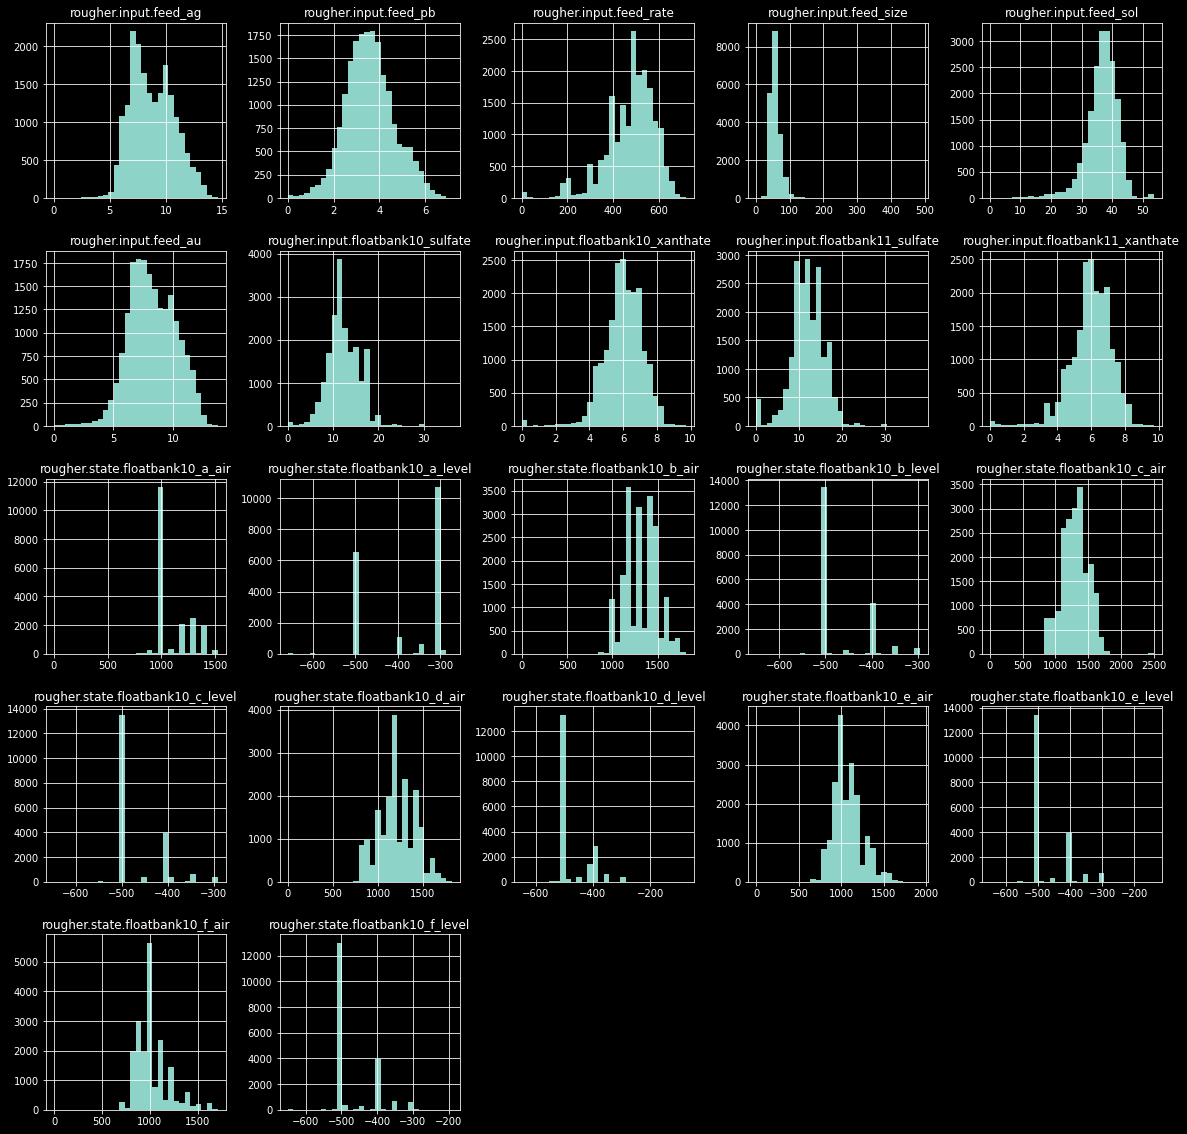

In [19]:
df_full[X_rougher].hist(figsize=(20, 20), bins=30)
plt.show()

Параметры флотационной установки имеют дискретное распределение и чаще всего устанавливаются на определенные значения с небольшими разбросами. 
Так, для уровня жидкости наиболее характерное значение минус 500 и минус 400 у.е., а для давления воздуха 1000-1500 о.е.

Количество сырья, а также размер частиц на этапе флотации имеют распределения близкие к нормальным. 
При этом, распределение размеров частиц имеет выбросы в несколько раз больше среднего значения.
В случае наличия существенных различий в обучающей и тестовой выборках, это может оказать существенный вклад в качество моделей машинного обучения.

In [20]:
def hist_feed_size(df, n):
    axs[n].hist(df['rougher.input.feed_size'],
                bins=30,
                range=(20, 100),
                density=True)
    axs[n].axvline(df['rougher.input.feed_size'].mean(),
                   color='tomato',
                   linewidth=3,
                   linestyle="--",
                   label='Среднее')
    axs[n].axvline(df['rougher.input.feed_size'].median(),
                   color='limegreen',
                   linewidth=3,
                   linestyle="--",
                   label='Медиана')

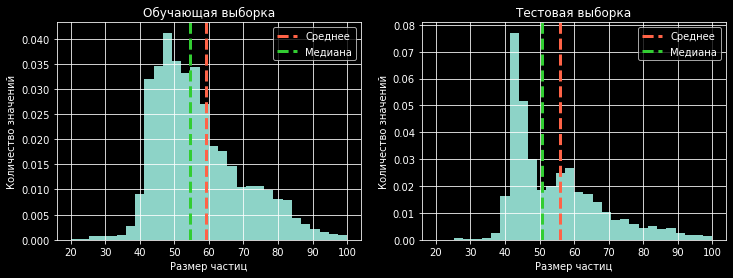

In [21]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

hist_feed_size(df_train, 0)
hist_feed_size(df_test, 1)

axs[0].set_title('Обучающая выборка')
axs[1].set_title('Тестовая выборка')

for i in range(2):
    axs[i].set_xlabel('Размер частиц')
    axs[i].set_ylabel("Количество значений")
    axs[i].grid(True)
    axs[i].legend()    
    
plt.show()

Диапазоны значений величин, а также их среднее и медиана, близкие в обоих выборках.
Таким образом, различия распределений не должны оказать существенного вклада в точность моделей. 

Для удобства анализа признаков этапа очистки разделим их на блоки первичной и вторичной очистки.

In [22]:
X_primary_cleaner = [x for x in X_final if 'primary_cleaner' in x]
X_secondary_cleaner = [x for x in X_final if x not in X_primary_cleaner]

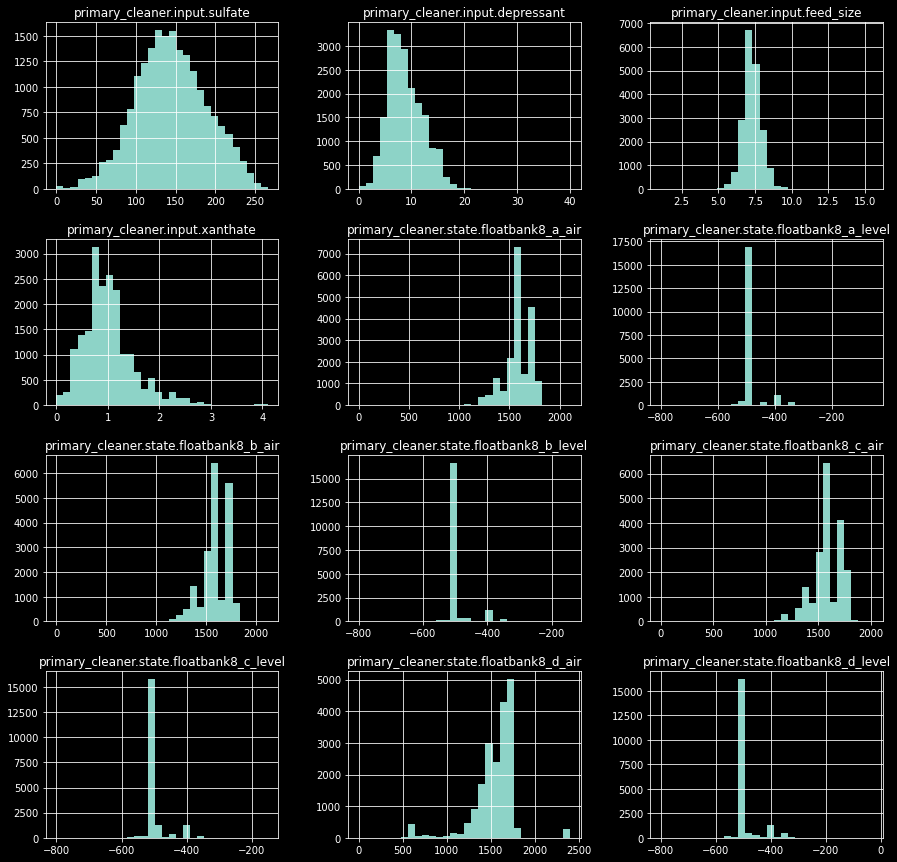

In [23]:
df_full[X_primary_cleaner].hist(figsize=(15, 15), bins=30)

plt.show()

Количества сырья, а также размер частиц на этапе предварительной очистки имеют распределения близкие к нормальным.
Параметры флотационной установки так же, как на этапе грубой очистки, имеют дискретные распределения.

Рассмотрим распределения признаков вторичной очистки.

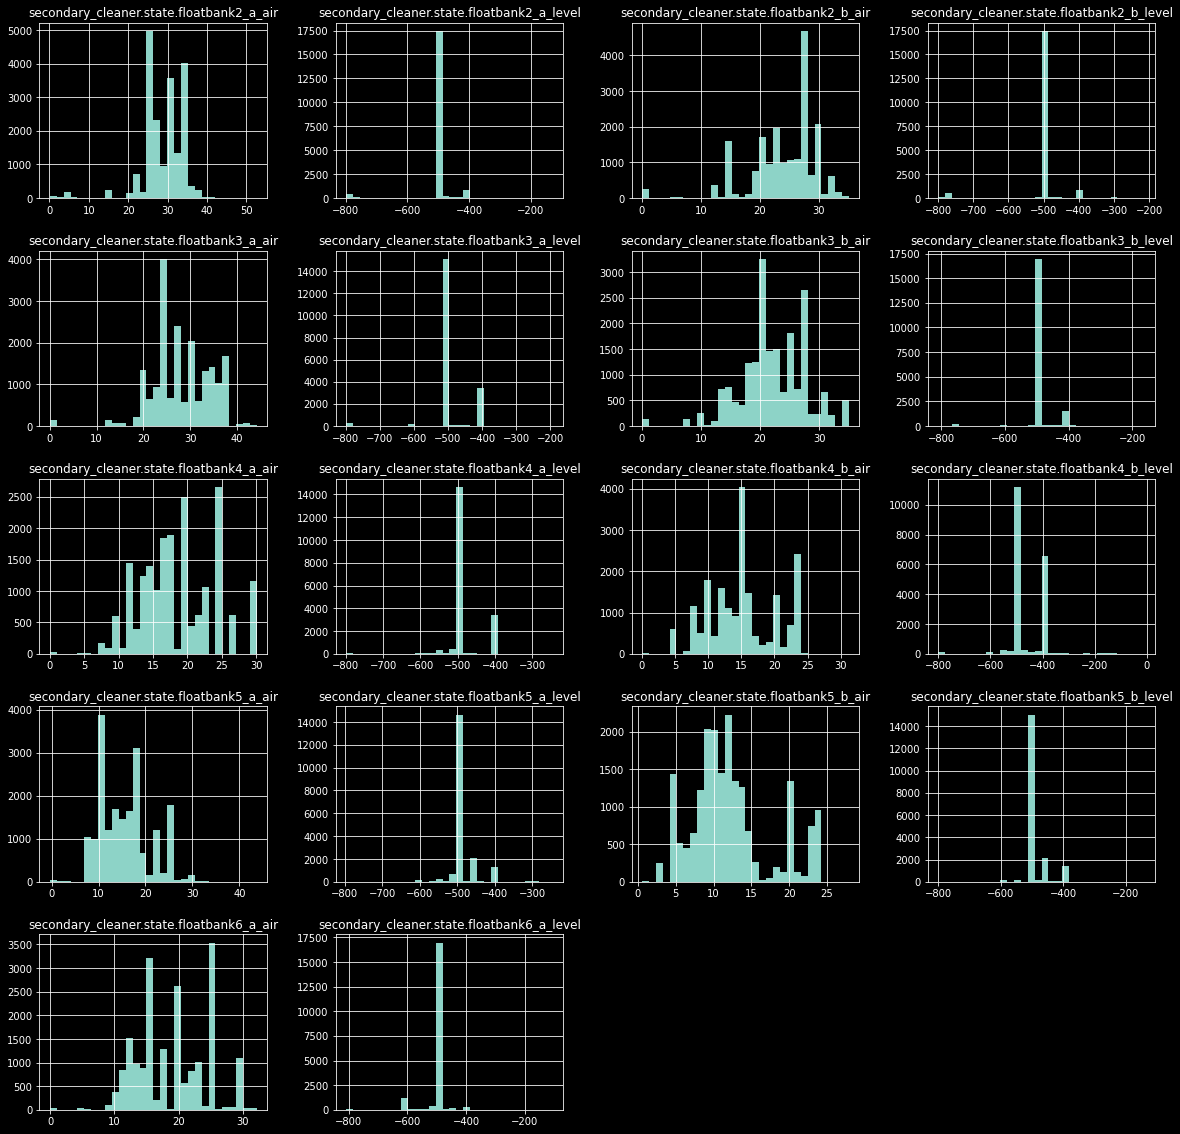

In [24]:
df_full[X_secondary_cleaner].hist(figsize=(20, 20), bins=30)

plt.show()

На этапе вторичной очистки рассматриваются только параметры флотационной установки, и они так же имеют дискретные распределения.

Рассмотрим изменения концентрации металлов на различных этапах очистки. 

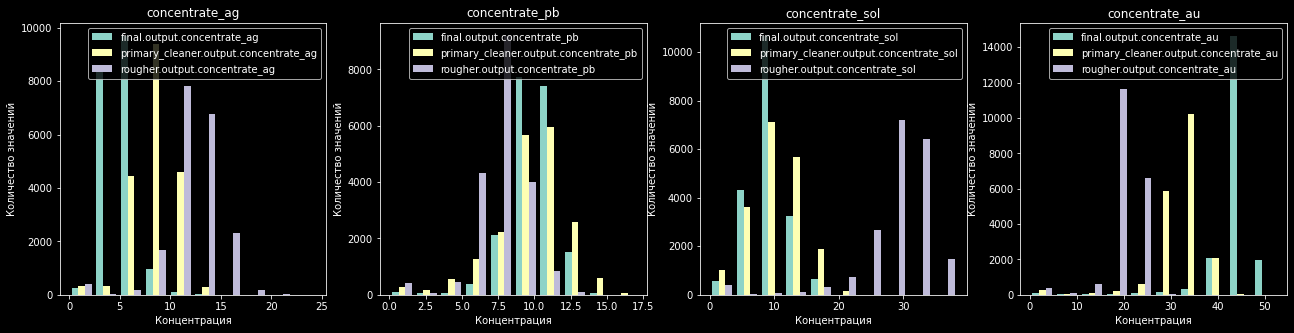

In [25]:
_, axs = plt.subplots(1, 4, figsize=(22, 5))
concentrates = [
    'concentrate_ag', 'concentrate_pb', 'concentrate_sol', 'concentrate_au'
]

for i in range(len(concentrates)):
    axs[i].hist(np.array(df_full[[x for x in features_output if concentrates[i] in x]]),
                label=[x for x in features_output if concentrates[i] in x], bins=10)
    axs[i].set_title(concentrates[i])
    axs[i].set_ylabel("Количество значений")
    axs[i].set_xlabel('Концентрация')
    axs[i].legend()    

Построенные графики хорошо иллюстрируют увеличение концентрации золота к окончанию технологического процесса и уменьшение концентрации серебра и солей.
При этом концентрация свинца при прохождении очистки изменяется в меньшей степени.

Посчитаем суммарную концентрацию всех веществ в исходном сырье и сравним ее с концентрацией в результате этапов флотации и очистки.

In [26]:
elements = ['ag', 'pb', 'sol', 'au']

elements_per_sum = ['rougher.input.elements_per_sum']
df_full[elements_per_sum[0]] = 0

for element in elements:
    df_full[elements_per_sum[0]] = df_full[elements_per_sum[0]] + df_full['rougher.input.feed_' + element]    
    
stages = ['rougher', 'final']
for stage in stages:
    feature_name = stage + '.elements_per_sum'
    elements_per_sum.append(feature_name)
    df_full[feature_name] = 0
    for consentrate in concentrates:
        df_full[feature_name] = df_full[feature_name] + df_full[stage + '.output.' + consentrate]

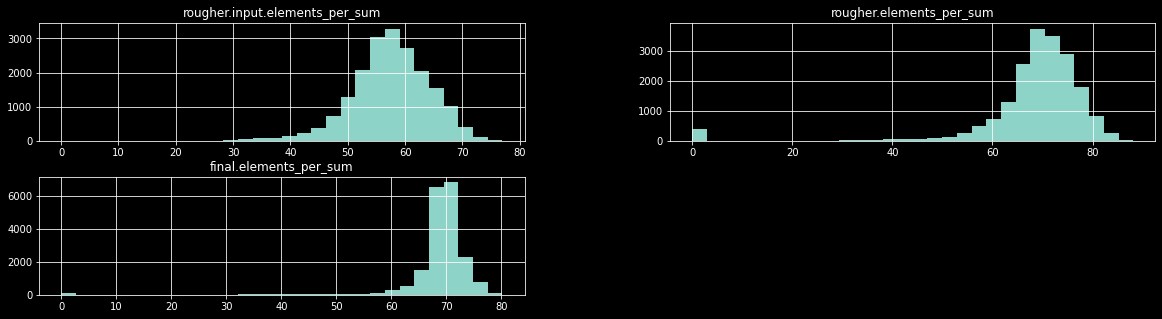

In [27]:
df_full[elements_per_sum].hist(figsize=(20, 5), bins=30)
plt.show()

По построенным гистограммам хорошо видно, что, в целом, распределение суммарного количества элементов не меняется от этапа к этапу.
При этом, наблюдаются выбросы в нулевых значениях, что кажется неправдоподобным.
Проверим правильность расчетов и выведем таблицу с нулевым значением суммы концентрации всех веществ на финальной стадии.

In [28]:
df_full[df_full[elements_per_sum[2]] == 0].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_calc,rougher.input.elements_per_sum,rougher.elements_per_sum,final.elements_per_sum
644,2016-02-13 11:00:00,0.0,0.0,0.0,0.0,0.0,8.894029,0.843584,15.417342,1.779052,133.610147,14.032789,7.32,1.550190,8.986696,6.530607,11.969464,26.238846,13.854131,2.156414,8.174442,1.965728,1800.648807,-349.517991,1799.347332,-350.925554,1798.833149,-349.609813,1456.714168,-350.518404,45778.313924,2952.203313,2943.136954,2.894754,7.407737,1.934178,500.087438,51.965198,31.762853,5.598971,10.251319,6.620908,10.259054,6.620118,11.803589,7.143475,21.692525,15.935190,68.960993,5.114923,0.925673,20.699912,2.293607,999.884600,-499.972731,1499.290173,-399.546180,1499.161769,-398.630471,1499.040323,-399.389036,1501.877151,-397.227473,1501.061312,-400.602849,11.838086,3.905472,10.651508,2.283842,32.054894,-400.832639,30.998499,-401.051170,30.900779,-400.953348,29.003189,-401.031397,21.991762,-399.587122,21.988937,-401.366408,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808,68.960993,46.703740,56.574778,0.0
1193,2016-03-11 10:00:00,0.0,0.0,0.0

В приведенной таблице хорошо видно, что сумма посчитана правильно, а концентрации всех элементов на этапе очистки равны нулю.
Кроме того, целевой признак так же равен нулю.
Такие значения маловероятны и, скорее всего, вызваны техническим сбоем.
Использование нулевых значений для целевых признаков может повредить обучению моделей и оценке их качества. 
Определим процентное отношение таких объектов в полной и обучающей выборках.

In [29]:
def zero_fetures(df):
    return len(df.loc[(df[y_final].values == 0) |
                      (df[y_rougher].values == 0)]) / len(df)

In [30]:
zero_fetures(df_full), zero_fetures(df_train)

(0.025207057976233346, 0.025207057976233346)

В обоих выборках процентное содержание объектов с нулевыми значениями целевых признаков менее 3%. 
Исключение такого количества данных не должно повлиять на качество моделей.

In [31]:
def drop_zero_features(df):
    return df.drop(index=df.loc[(df[y_final] == 0)
                                | (df[y_rougher] == 0)].index)

In [32]:
df_full, df_train = drop_zero_features(df_full), drop_zero_features(df_train)
zero_fetures(df_full), zero_fetures(df_train)

(0.0, 0.0)

Нулевых признаков в полной и обучающей выборках не осталось.
В тестовой выборке целевые признаки отсутствуют.

## Анализ взаимосвязей между данными

Определим наличие взаимосвязей между данными в разных столбцах. 
Для этого используем библиотеку phik, которая определяет нелинейные взаимосвязи, в том числе, категориальных и ординарных переменных, и рассчитаем соответствующие матрицы.

In [33]:
phik_matrix_rougher = df_full[X_rougher + [y_rougher]].phik_matrix(dropna=False)
phik_matrix_final = df_full[X_final + [y_rougher] +
                             [y_final]].phik_matrix(dropna=False)

interval columns not set, guessing: ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level', 'rougher.output.recovery']
interval columns not set, guessing: ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.f

Построим heatmap для определенных матриц по целевым признакам. 

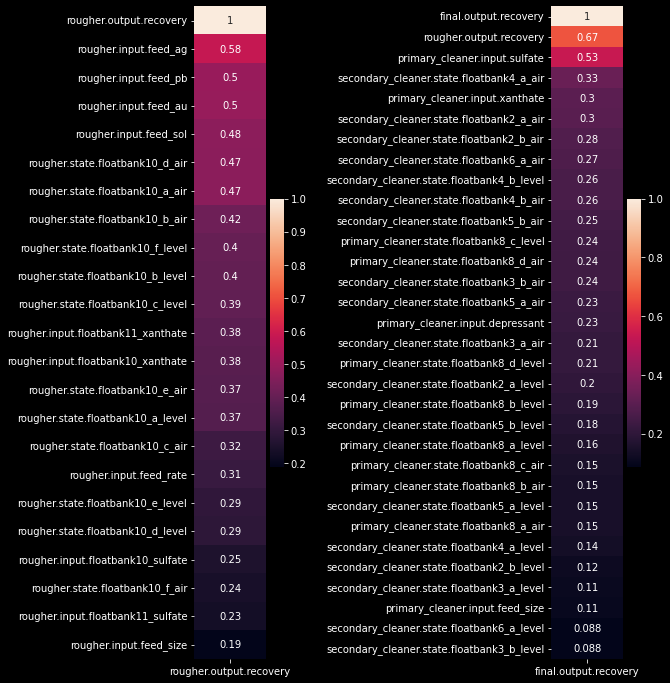

In [34]:
fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(1, 2, wspace=3)
ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(phik_matrix_rougher[[y_rougher]].sort_values(by=[y_rougher],
                                                             ascending=False),
                  annot=True)
ax2 = fig.add_subplot(gs[1])
ax2 = sns.heatmap(phik_matrix_final[[y_final]].sort_values(by=[y_final],
                                                         ascending=False),
                  annot=True)
plt.show()

По представленному рисунку видно, что на коэффициент восстановления золота на этапе флотации параметры флотационной установки и количество серебра в сырье влияют больше, чем количество самого золота. 

В наибольшей степени коэффициент восстановления золота на этапе очистки зависит от аналогичного коэффициента на этапе обработки сырья.
Следующим по значимости является признак `primary_cleaner.input.sulfate`, а наименьший вклад оказывают параметры флотационной установки вторичной очистки.

В целом, все рассматриваемые параметры влияют на целевые признаки и все следует использовать для разработки моделей машинного обучения.

Рассмотрим взаимосвязи между признаками, построив heatmap для полных матриц коэффициентов корреляции.

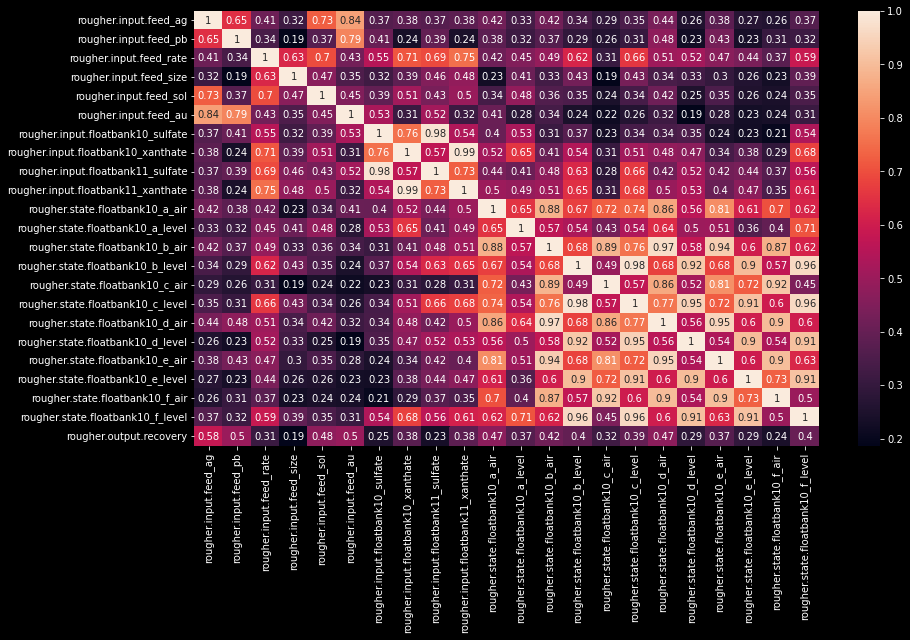

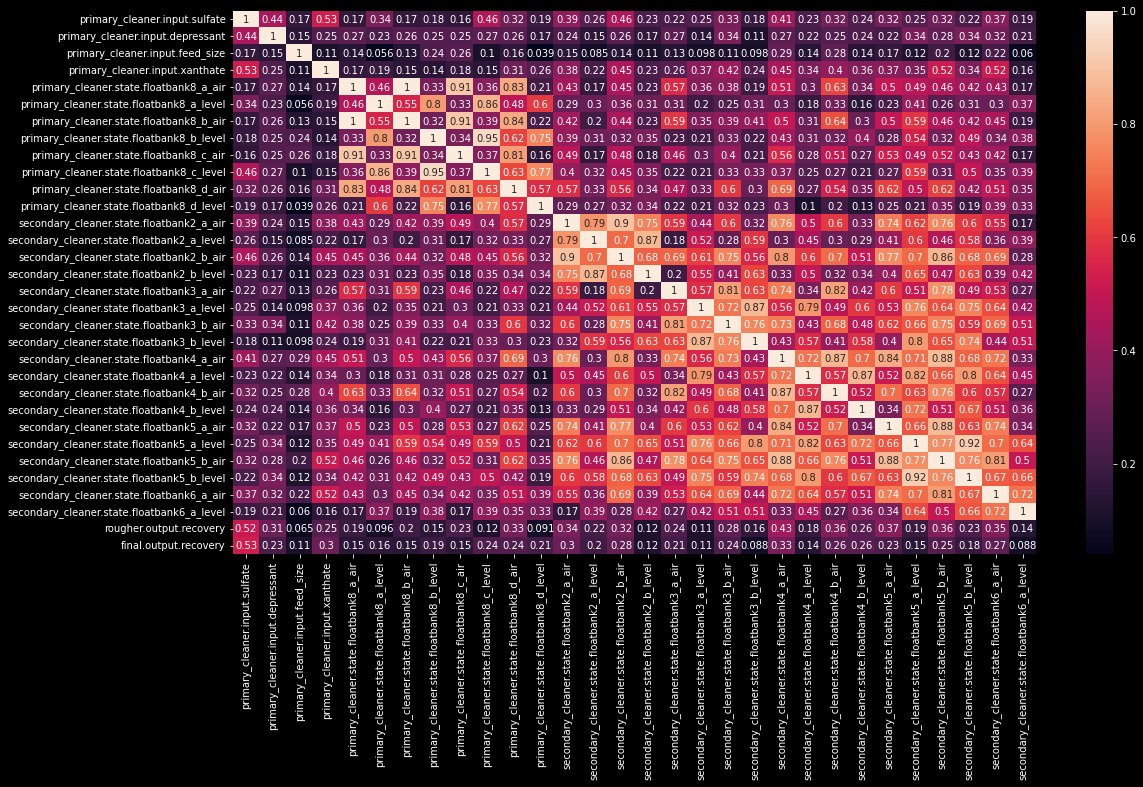

In [35]:
fig = plt.figure(figsize=(14, 8))
sns.heatmap(phik_matrix_rougher[X_rougher], annot=True)
plt.show()

fig = plt.figure(figsize=(18, 10))
sns.heatmap(phik_matrix_final[X_final], annot=True)
plt.show()

По полученным рисункам видно, что большая часть признаков обладает высоким коэффициентом корреляции друг с другом и являются коллинеарными.
Исключение таких признаков из рассмотрения помогает повысить интерпретируемость моделей машинного обучения и уменьшить время, необходимое для их обучения.
Для этого определим функцию, которая формирует список только тех признаков, коэффициент корреляции которых меньшего некоторого значения.
В качестве такого значения для выберем 0,9.  
На этапе обучения моделей рассмотрим, на сколько это оправдано в настоящей задаче.

In [36]:
def remove_collinear_features(phik_matrix, X, threshold):
    '''
    Source: https://stackoverflow.com/a/43104383
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient (phik)
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        phik_matrix: phik_matrix
        X: list of analising fetures
        threshold: features with correlations greater than this value are removed

    Output: 
        List of features that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = phik_matrix[X]
    iters = range(len(corr_matrix.columns) - 1)
    drops = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i + 1):
            item = corr_matrix.iloc[j:(j + 1), (i + 1):(i + 2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                drops.append(col.values[0])

    drops = set(drops)
    features = phik_matrix[X].drop(columns=drops).columns

    return features.tolist()

In [37]:
X_rougher_cut = remove_collinear_features(phik_matrix_rougher, X_rougher, 0.9)
X_final_cut = remove_collinear_features(phik_matrix_final, X_final, 0.9)

## Нормализация данных

Учитывая, что диапазоны значений различных признаков лежат в разных интервалах, для уравновешивания качества различных моделей представляется целесообразным нормализация исходных данных.
Для этого воспользуемся соответствующей функцией библиотеки Sklearn. 

In [38]:
scaler = MinMaxScaler()
scaler.fit(df_test[X_rougher_cut + X_final_cut])
df_train[X_rougher_cut + X_final_cut] = scaler.transform(df_train[X_rougher_cut + X_final_cut])
df_test[X_rougher_cut + X_final_cut] = scaler.transform(df_test[X_rougher_cut + X_final_cut])

## Заключение по EDA

Проведен исследовательский анализ данных, в ходе которого исправлен тип данных для хранения дат и устранены пропуски.  

Рассмотрены распределения значений признаков.
Получено, что часть из них (такие как параметры флотационной установки) имеют дискретное распределение, а распределения других (количество сырья, размер частиц и др.) близки к нормальным.

Анализ концентрации веществ на разных стадиях показал наличие аномалий в данных в виде нулевых значений целевых признаков. 
Такие значения маловероятны и, скорее всего, вызваны техническим сбоем.
Количество таких аномалий составляет около 2,5%, что позволяет их исключить из рассмотрения без существенной потери точности решаемой задачи.

Определены взаимосвязи между данными в разных столбцах. 
Получено, что на целевой признак этапа флотации в большей степени влияют параметры флотационной установки и количество серебра в сырье. 
При этом, аналогичный признак этапа очистки, в первую очередь, от качества очистки на этапе обработки сырья и количества сульфата на первичной обработке.

Анализ взаимосвязей между нецелевыми признаками показал наличие высоких коэффициентов корреляции между большей их частью. 
Другими словами, многие из признаков являются коллинеарными, а их исключение из рассмотрения помогает повысить интерпретируемость моделей и уменьшить время, необходимое для их обучения.
В этой связи список признаков сокращен до таких признаков, коэффициент корреляции которых больше 0,9.  
На этапе обучения моделей покажем, на сколько это оправдано в настоящей задаче.

Для уравновешивания качества различных моделей выполнена нормализация исходных данных.

# Моделирование

## Baseline

Определение качества моделирования будем проводить, сравнивая с метриками опорной модели, которая вместо предсказаний подставляет средние значения целевых признаков из обучающей выборки.

In [39]:
df_test[y_rougher + '_baseline'] = df_train[y_rougher].mean()
df_test[y_final + '_baseline'] = df_train[y_final].mean()
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_baseline,final.output.recovery_baseline
0,2016-09-01 00:59:59,0.790514,0.374768,0.246700,0.244062,0.665198,0.399786,1399.144926,0.456412,1400.102998,-500.704369,0.731215,0.468615,0.907675,0.808659,0.692420,0.159675,0.780062,0.874856,0.696956,0.690570,16.867518,6.150709,0.703913,0.800806,0.732393,0.713368,0.721983,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,0.774514,0.586257,0.530598,0.508327,0.499929,0.719011,0.436559,0.592205,0.400094,0.758356,0.256371,0.377108,0.312721,0.660238,0.320414,-500.037437,1.000000,0.451656,85.096348,67.454148
1,2016-09-01 01:59:59,0.807945,0.374627,0.246700,0.240511,0.665102,0.400014,1398.055362,0.456628,1396.151033,-499.240168,0.731480,0.467162,0.901006,0.791976,0.692859,0.157766,0.764039,0.862311,0.700237,0.673237,16.996063,6.002315,0.701694,0.800482,0.731606,0.710986,0.721847,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,0.774053,0.587656,0.530004,0.507046,0.499188,0.719591,0.439865,0.591830,0.401245,0.756096,0.260027,0.379191,0.313186,0.491072,0.320882,-500.162375,0.937057,0.451496,85.096348,67.454148
2,2016-09-01 02:59:59,0.807441,0.322058,0.216920,0.241871,0.664967,0.398916,1398.860436,0.456648,1398.075709,-502.151509,0.731474,0.468256,0.908387,0.776972,0.692171,0.170360,0.790120,0.875406,0.699824,0.656580,16.982096,5.853594,0.701572,0.802153,0.731047,0.710082,0.721092,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,0.773591,0.586643,0.532335,0.506654,0.500467,0.719284,0.439393,0.592486,0.398058,0.755916,0.258937,0.377689,0.317664,0.536361,0.322820,-499.828510,0.936121,0.450326,85.096348,67.454148
3,2016-09-01 03:59:59,0.807731,0.300103,0.202030,0.209527,0.665501,0.401632,1397.440120,0.457490,1400.129303,-498.355873,0.732293,0.466191,0.855061,0.729957,0.673793,0.152427,0.761587,0.882263,0.680863,0.651115,16.515277,5.803657,0.702808,0.801141,0.733321,0.714652,0.722413,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986,0.773130,0.588548,0.529500,0.508586,0.500252,0.721117,0.437398,0.592707,

Для расчета метрик качества добавим в тестовую выборку значения целевых переменных из полной выборки, а также создадим функции для расчета sMAPE для отельного признака и итоговой sMAPE.

In [40]:
df_test = df_test.merge(df_full[[y_final, y_rougher, 'date']], on='date', how='left')

In [41]:
def smape_manual(y_true, feature_end):
    return 100 / len(df_test[y_true]) * np.sum(
        2 * np.abs(df_test[y_true] - df_test[y_true + feature_end]) /
        (np.abs(df_test[y_true]) + np.abs(df_test[y_true + feature_end])))

def smape_total(feature_end):
    return 0.25 * smape_manual(y_rougher, feature_end) + 0.75 * smape_manual(
        y_final, feature_end)

In [42]:
smape_manual(y_rougher, '_baseline')

4.902503516921294

In [43]:
smape_manual(y_final, '_baseline')

8.011115060975808

In [44]:
smape_total('_baseline')

7.233962174962179

Полученные значения представлены в процентном соотношении и являются предельными для проектирования моделей машинного обучения.

## Разработка модели для этапа флотации

Рассмотрим три типа моделей: линейную регрессию, дерево решений и случайный лес и определим лучшую из них.
Для этого сперва определим сами модели.

In [45]:
model_lr = LinearRegression()
model_dt = DecisionTreeRegressor(random_state=26)
model_rf = RandomForestRegressor(random_state=26)

Сравним модели при помощи функции расчета перекрестной валидации.
В качестве оцениваемой метрики используем sMAPE, для чего определим ее при помощи функции make_scorer.
Для соответствия синтаксису последней переопределим функцию расчета самой метрики.

In [46]:
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_true - y_pred) /
                                      (np.abs(y_true) + np.abs(y_pred)))


smape_score = make_scorer(smape, greater_is_better=False)

In [47]:
def cvs(model, X, y):
    return sorted(-1 * cross_val_score(
        model, df_train[X], df_train[y], cv=15, n_jobs=-1,
        scoring=smape_score))


def cvs_table(X, y):

    return pd.DataFrame({
        'linear': cvs(model_lr, X, y),
        'tree': cvs(model_dt, X, y),
        'forest': cvs(model_rf, X, y)
    })

Результаты расчета функции перекрестной валидации наглядно отобразить при помощи heatmap.
Сразу проведем сравнение количества признаков, используемых для обучения и работы модели.

In [48]:
cvs_rougher_cut = cvs_table(X_rougher_cut, y_rougher)
cvs_rougher = cvs_table(X_rougher, y_rougher)

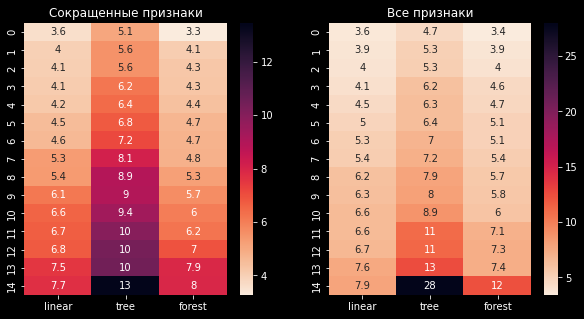

In [49]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(cvs_rougher_cut, annot=True, cmap=sns.cm.rocket_r)
ax1.set_title('Сокращенные признаки')
ax2 = fig.add_subplot(gs[1])
ax2 = sns.heatmap(cvs_rougher, annot=True, cmap=sns.cm.rocket_r)
ax2.set_title('Все признаки')
plt.show()

Построенный рисунок отображает значения, близкие к предельным рассматриваемой метрики для соответствующей модели.
К предельным относятся значения, полученные при идеально настроенных гиперпараметрах модели и большом наборе обучающих данных.  
Кроме того, по рисунку можно сделать следующие выводы:  
1. метрики всех моделей могут быть как лучше, так и хуже метрики опорной модели (Baseline);  
1. модель дерева решений показывает наихудший результат, а модель линейной регрессии - наилучший;
1. при сокращении количества признаков метрика модели линейной регрессии улучшается, а случайного леса - ухудшается.

Полученный результат объясняется высокой коллинеарностью признаков и высокой степенью линейной зависимости некоторых из них с целевым признаком. 

Исследуем оптимальность выбранного порога коэффициента корреляции для сокращения количества признаков, в том числе и на тестовой выборке.
Для этого сперва создадим функцию по обучению, предсказанию и расчету sMAPE, а затем переберем порог коэффициента корреляции.

In [50]:
def fit_predict_smape(model, X, y, feature_end):
    model = model.fit(df_train[X], df_train[y])
    df_test[y + feature_end] = model.predict(df_test[X])
    df_train[y + feature_end] = model.predict(df_train[X])
    return smape_manual(y, feature_end)

In [51]:
def best_cvs(X, y, phik_matrix):

    X_cut_optimus = []
    linear_optimus = []
    forest_optimus = []
    lengths = []
    smapes_ln = []
    smapes_rf = []

    for i in [round(x, 2) for x in np.linspace(.1, 1, num=19)]:
        X_cut_optimus = remove_collinear_features(phik_matrix, X, i)
        if y == y_final:
            X_cut_optimus.append(y_rougher + '_lr')

        if len(X_cut_optimus) not in lengths:
            lengths.append(len(X_cut_optimus))
            linear_optimus.append(cvs(model_lr, X_cut_optimus, y)[0])
            forest_optimus.append(cvs(model_rf, X_cut_optimus, y)[0])
            smapes_ln.append(
                fit_predict_smape(model_lr, X_cut_optimus, y, '_lr'))
            smapes_rf.append(
                fit_predict_smape(model_rf, X_cut_optimus, y, '_rf'))

    best_cvs = pd.DataFrame(
        {
            'linear': linear_optimus,
            'forest': forest_optimus,
            'test_ln': smapes_ln,
            'test_rf': smapes_rf
        },
        index=lengths)
    best_cvs['differs_ln'] = best_cvs['test_ln'] - best_cvs['linear']
    best_cvs['differs_rf'] = best_cvs['test_rf'] - best_cvs['linear']

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)
    ax1 = fig.add_subplot(gs[0])
    ax1 = sns.heatmap(best_cvs[['linear', 'forest']],
                      annot=True,
                      fmt='.3g',
                      cmap=sns.cm.rocket_r)
    ax2 = fig.add_subplot(gs[1])
    ax2 = sns.heatmap(best_cvs[['test_ln', 'test_rf']],
                      annot=True,
                      fmt='.3g',
                      cmap=sns.cm.rocket_r)
    ax3 = fig.add_subplot(gs[2])
    ax3 = sns.heatmap(best_cvs[['differs_ln', 'differs_rf']],
                      annot=True,
                      fmt='.3g',
                      cmap=sns.cm.rocket_r)
    plt.show()

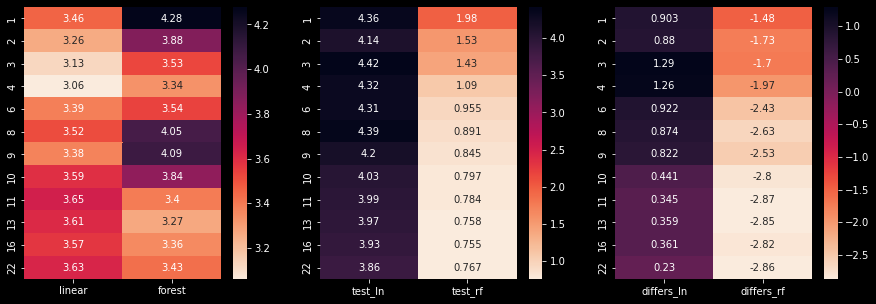

In [52]:
best_cvs(X_rougher, y_rougher, phik_matrix_rougher)

По рисунку видно, что метрика качества модели линейной регрессии практически при любом количестве признаков лучше метрики модели случайного леса.
Минимальное значение достигается при использовании четырех признаков.  
Также для этой модели при количестве признаков равном 2 различие метрики на обучающей и тестовой выборке минимальны.
С увеличением количества признаков резко увеличивается разница, что говорит о переобучение модели. 
Полученный факт подтверждает коллинеарность признаков и показывает их "повторяемость" друг друга с точки зрения целевого признака.

Таким образом, оптимальным значением признаков для модели линейной регрессии на этапе rougher является два, а их коэффициент корреляции не превосходит 0,5. 
Выведем эти признаки и итоговое значение sMAPE для рассматриваемой модели.

In [53]:
X_rougher_lr_best = remove_collinear_features(phik_matrix_rougher, X_rougher, 0.5)
X_rougher_lr_best

['rougher.input.feed_ag', 'rougher.input.feed_rate']

In [54]:
smape_rougher_lr = fit_predict_smape(model_lr, X_rougher_lr_best, y_rougher, '_lr')
smape_rougher_lr

4.143562274498229

Полученная модель почти на 1% лучше опорной модели. 

Метрики модели случайного леса на тестовой выборке тем меньше, чем больше количество признаков. 
Аналогичным образом ведет себя и характеристика обучаемости модели - разница между предсказаниями.
В то же время различие между лучшими значениями метрик моделей случайного леса и линейной регрессии не превосходят 0,9%.
В этой связи представляется целесообразным провести анализ чувствительности метрики к гиперпараметрам.
Возможно, существует такой их набор, при котором коллинеарность признаков будет невилироавться, а метрика качества будет выше, чем для модели линейной регрессии.

С этой целью определим пространство гиперпараметров и произведем их подбор алгоритмом случайного подбора.

In [55]:
#Пространство параметров случайного леса
n_estimators = [int(x) for x in np.linspace(start=50, stop=250, num=20)]
min_samples_split = [int(x) for x in np.linspace(2, 5, num=4)]
min_samples_leaf = [int(x) for x in np.linspace(2, 30, num=10)]
max_depth = [int(x) for x in np.linspace(10, 55, num=10)]
max_leaf_nodes = [int(x) for x in np.linspace(2, 50, num=20)]

space_rf = {
    'n_estimators': n_estimators,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

model_rf_rougher_best = RandomizedSearchCV(estimator=RandomForestRegressor(
    random_state=26, n_jobs=-1),
                                      param_distributions=space_rf,
                                      n_jobs=-1,
                                      cv=5,
                                      n_iter=50,
                                      scoring=smape_score,
                                      random_state=26)

In [56]:
model_rf_rougher_best = model_rf_rougher_best.fit(df_train[X_rougher],
                                        df_train[y_rougher])

Выведем значения гиперпараметров обученной модели случайного леса, а также значение ее sMAPE на обучающей и тестовой выборках.

In [57]:
model_rf_rougher_best.best_params_

{'n_estimators': 207,
 'min_samples_split': 3,
 'min_samples_leaf': 26,
 'max_leaf_nodes': 47,
 'max_depth': 25}

In [58]:
model_rf_rougher_best.best_score_ * -1

5.747579686141986

In [59]:
df_test[y_rougher + '_rf_best'] = model_rf_rougher_best.predict(df_test[X_rougher])
smape_manual(y_rougher, '_rf_best')

3.06115966321264

Полученное значение метрики на тестовой выборке меньше лучшего значения для модели линейной регрессии на 0,4%.
В то же время, оно меньше аналогичного на обучающей на 2,3%, что может быть показателем ее недообучения и непредсказуемого (случайного) поведения.  
Таким образом, несмотря на подбор гиперпараметров, лучшим типом модели машинного обучения для этапа флотации остается модель линейной регрессии.

## Разработка модели для этапа очистки

Аналогичным способом проанализируем пригодность тех же типов моделей для решения задачи предсказания коэффициента восстановления золота на этапе очистки.
Для этого добавим в перечень признаков модели финального этапа результат работы модели этапа флотации, а затем воспользуемся уже определенными функциями. 

In [60]:
X_final_cut.append(y_rougher + '_lr')

cvs_final_cut = cvs_table(X_final_cut, y_final)

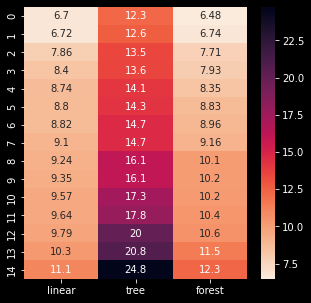

In [61]:
fig = plt.figure(figsize=(5, 5))
sns.heatmap(cvs_final_cut, annot=True, fmt='.3g', cmap=sns.cm.rocket_r)
plt.show()

Аналогично результату анализа моделей на этапе флотации модель дерева решений показывает наихудший результат.
В то же время метрика модели случайного на 0,2% лучше метрики линейной регрессии, что может быть обусловлено неудачным выбором используемых признаков.

Проведем поиск оптимального числа признаков для работы моделей.

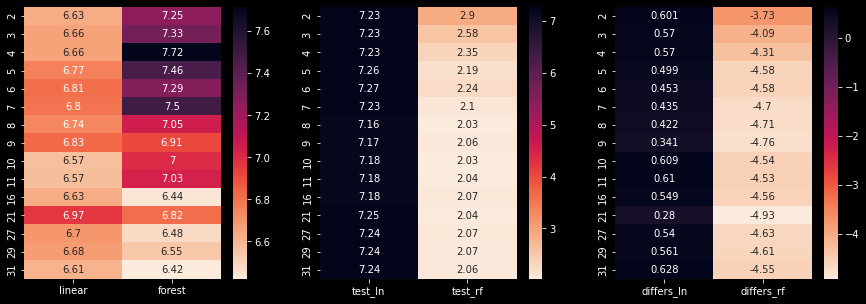

In [62]:
best_cvs(X_final, y_final, phik_matrix_final)

По рисунку хорошо видно, что аналогично результатам разработки моделей этапа флотации, модель линейной регрессии показывает лучший результат.
При этом, количество признаков, равное десяти обеспечивает оптимальное обучение с точки зрения баланса обучаемости.
С указанным количеством признаков предсказания целевого признака на тестовой выборке составляет 7,7%, что на 0,6% лучше опорной модели.  
Выведем признаки, использованные в модели.

In [63]:
X_final_cut_best = remove_collinear_features(phik_matrix_final, X_final, 0.7)
X_final_cut_best.append(y_rougher + '_lr')
X_final_cut_best

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_a_level',
 'rougher.output.recovery_lr']

Запишем результаты работы модели в соответствующий столбец тестовой выборки и посчитаем итоговую метрику.

In [64]:
smape_final_lr = fit_predict_smape(model_lr, X_final_cut_best, y_final, '_lr')
smape_final_lr

7.182256950192234

In [65]:
smape_total('_lr')

6.422583281268733

# Выводы
Проведено моделирование для предсказания коэффициента восстановления золота из золотосодержащей руды.

Разработана опорная модель, предсказывающая среднее значение целевых признаков обучающей выборки.  

Проанализированы три типа моделей: линейная регрессия, дерево решений и случайный лес.
При помощи метода кроссвалидации показано, что модель дерева решений неприменима к настоящей задаче.
Анализ оставшихся моделей на обоих этапах - флотации и очистки, показал преимущество модели линейной регрессии.
Это объясняется тем, что многие признаки имеют высокую корреляцию между собой и использование их полного переченя нецелесообразно.
Так, для этапа флотации лучшее качество показывает модель только с двумя признаками - 'rougher.input.feed_ag' и 'rougher.input.feed_rate'.
Столь малое количество существенно ограничивает перечень типов моделей машинного обучения, возможных для обучения, и делает модель линейной регрессии оптимальной для использования.  
На этапе очистки лучшие метрики модели достигаются при использовании десяти признаков, включая целевой признак модели этапа флотации.

Результаты моделирования сведены в таблицу, из которой следует, что обученная модель позволяет предсказывать итоговую метрику на 0,7% лучше относительно опорной модели.

| Параметр | sMAPE(rougher.output.recovery) | sMAPE(final.output.recovery) | sMAPE(total) |
|-|-|-|-|
| Baseline | 5,2% | 8,3% | 7,6% |
| Линейная регрессия | 4,2% | 7,7% | 6,9% |

Учитывая относительно небольшое различие метрик моделей линейной регрессии и опорной, рекомендуется провести поиск в научной литературе аналитических зависимостей целевых признаков с признаками, оказывающими наибольший вклад в качество моделей.
Использование таковых позволит существенно повысить качество моделей. 

Тем не менее, разработанная модель машинного обучения позволяет решить поставленную задачу и предсказывает коэффициент восстановления золота из золотосодержащей руды.  
Для дальнейшей оптимизации производства целесообразно определить цену одного процента по рассматриваемой метрике.